In [1]:
%matplotlib inline
from prophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = 9, 6

As a result of the lockdowns caused by the COVID-19 pandemic, many time series experienced "shocks" during 2020. Some examples are:

* Online activity spiking - media (Netflix, YouTube, etc.) consumption, e-commerce (Amazon, eBay) purchases, social media, etc.
* Physical activity declining heavily - restaurant visits, cinema sales, etc.

Along with a heavy increase or decline around the time of the lockdown, most of these time series would also afterwards maintain a higher or lower average level compared to pre-COVID. These levels may fluctuate again as lockdowns are loosened and tightened in response to outbreaks, or with the rollout of vaccines.

Finally, seasonal patterns could have changed: for example, people may have consumed less media (in total hours) on weekdays compared to weekends before the COVID lockdowns, but during lockdowns weekday consumption could be much closer to weekend consumption.

All of the above presents some tough challenges for forecasting:

1. Models shouldn't assume the one-off spikes at the beginning of COVID will occur again in the near term.
2. Models should properly capture the changes in the underlying trend cause by medium/long-term changes people's activity as a result of lockdowns.
3. Models should properly capture any changes in seasonality caused by changes in people's routines (work from home, less going out, etc.).

It's unlikely that our models will be able to do all of the above. Furthermore, other influences like the rollout of vaccines, and repeated lockdowns caused by second/third waves, are impossible to predict.

In this page we suggest some strategies to help _mitigate_ (but not necessarily fully solve) the impact of COVID-19 lockdowns in time series projections.

#### Case Study - Pedestrian Activity

The dataset we will use to demonstrate these strategies is [Pedestrian Sensor data from the City of Melbourne](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp). This data measures foot traffic from sensors in various places in the Central Business District (CBD) in Melbourne, Australia. For this case study, we've taken data from the sensor with the most volume (`Sensor_ID = 4, Town Hall (West)`), and aggregated the data to the daily level (the original dataset provides hourly counts) from May 2009 to May 2021. The aggregated dataset can be found in the examples folder [here](https://github.com/facebook/prophet/tree/master/examples/example_pedestrians.csv).

In [2]:
df = pd.read_csv('../examples/example_pedestrians.csv')

The full history of data (May 2009 to May 2021):

<AxesSubplot:xlabel='ds'>

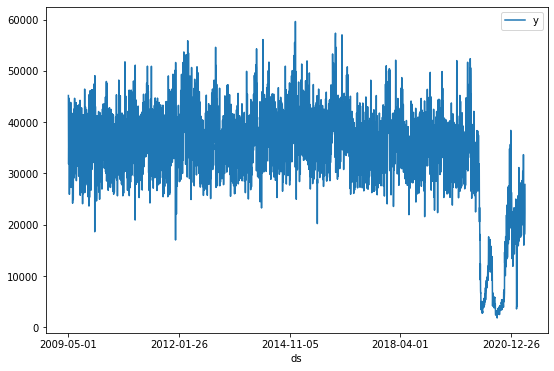

In [3]:
df.set_index('ds').plot()

Zooming in closer to the COVID impacts:

<AxesSubplot:xlabel='ds'>

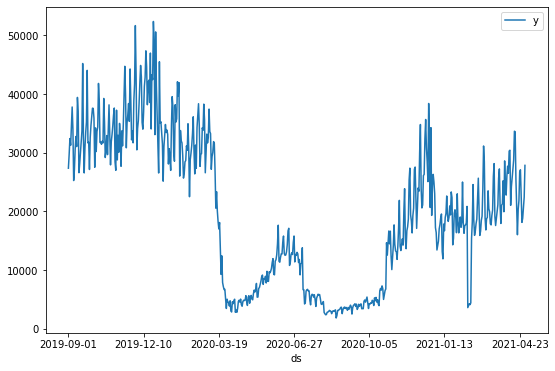

In [4]:
df.loc[df['ds'] >= '2019-09-01'].set_index('ds').plot()

We can see two key events in the time series:

* The initial drop in foot traffic around 21 March 2021, which started to recover around 6 June 2020. This corresponds to the declaration of a pandemic by WHO and subsequent lockdowns mandated by the Victorian government.
* After some slow recovery, a second drop in foot traffic around July 9 2020, which began to recover around 27 October 2020. This corresponds to the "second wave" of the pandemic in metropolitan Melbourne.

There haven't been any significant lockdowns after the second wave; there was strict lockdown in February 2021 but that only lasted roughly 5 days.

#### Default model without any adjustments

First we'll fit a model with the default Prophet settings:

In [5]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

In [6]:
forecast = m.predict(future)

Text(0.5, 1.0, 'Default Prophet')

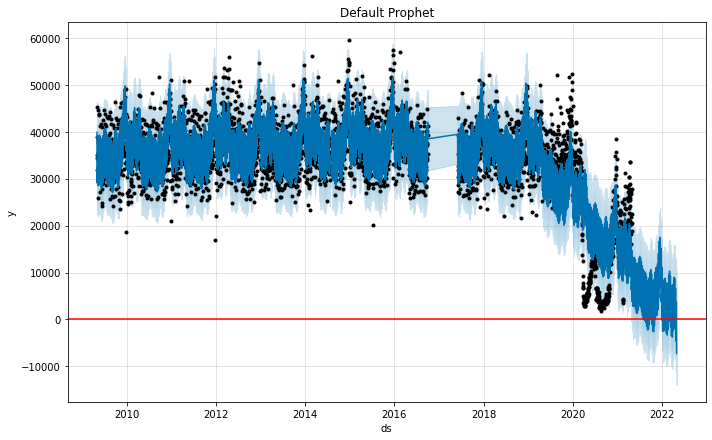

In [7]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet')

The forecast from the default Prophet model for this dataset shows the following issues:

* The model doesn't pick up the low foot traffic around mid-March 2020, then later from early July to mid-October 2020, as outliers, and instead incorporates them into the trend.
* The model does not pick up the increasing trend in early 2021, when lockdowns were loosened.
* The negative sloping trend causes predictions to go negative in late 2021 and 2022.

### Treating COVID-19 lockdowns as a one-off holidays

This first strategy treats the days impacted by COVID-19 as a holiday that will not repeat again in the future. Adding custom holidays is explained in more detail [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events). The lockdowns dataframe can be set up like so:

In [8]:
# Lockdown 1 = 2020-03-21 to 2020-06-06 inclusive
# Lockdown 2 (second wave) = 2020-07-09 to 2021-10-27 inclusive
lockdowns = pd.DataFrame({
    'holiday': ['lockdown1', 'lockdown2'],
    'ds': pd.to_datetime(["2020-03-21", '2020-07-09']),
    'lower_window': [0, 0],
    'upper_window': [78, 110],
})

lockdowns

,holiday,ds,lower_window,upper_window
0,lockdown1,2020-03-21,0,78
1,lockdown2,2020-07-09,0,110


* We have an entry for each lockdown period, with `ds` specifying the start of the lockdown.
* We specify `upper_window` to denote that the effect of the lockdown spans for x days after the start of the lockdown.

Note that since we don't specify any future dates, Prophet will assume that these holidays will _not_ occur again when creating the future dataframe (and hence they won't affect our projections). This is different to how we would specify a recurring holiday.

In [9]:
m2 = Prophet(holidays=lockdowns)
m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)

In [10]:
forecast2 = m2.predict(future2)

Text(0.5, 1.0, 'Lockdowns as one-off holidays')

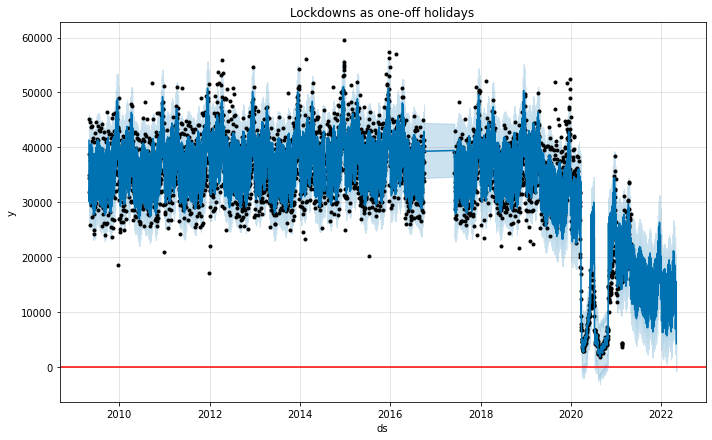

In [11]:
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays')

The forecasts already look more reasonable by specifying the two lockdown periods as holidays:

* The forecasts no longer become negative in late 2021.
* Prophet is able to fit the historical shocks in the time series (with a recovery in between). 

We can also plot the model components to check the magnitude of the effect that Prophet is "attributing" to the lockdowns:

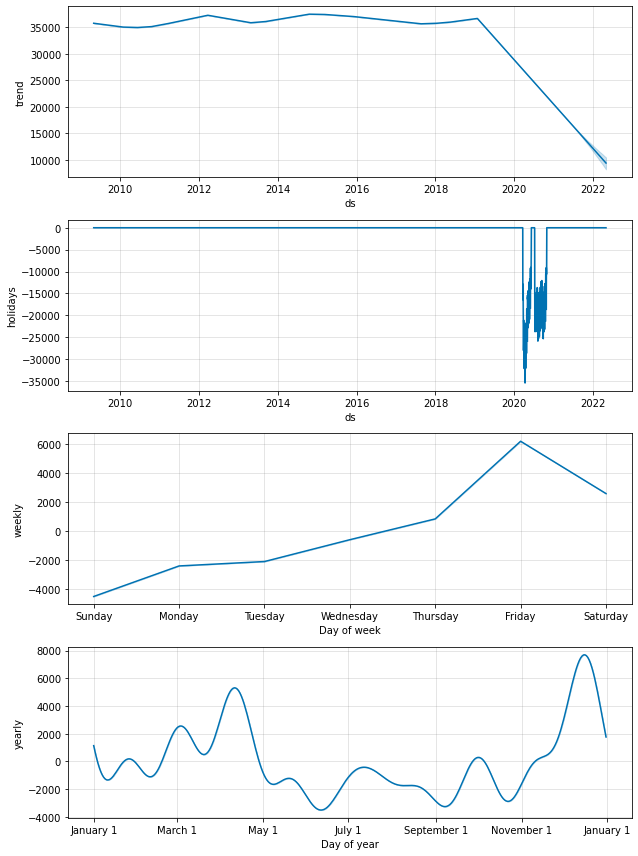

In [12]:
m2.plot_components(forecast2)
plt.show()

* Prophet is sensibly assigning a large negative effect to the days within the lockdown periods.
* Day-of-year seasonality also looks reasonable (i.e. March and July seasonality don't seem to be impacted too heavily by the 2020 shocks).

However, the trend component is still has a negative slope from 2020 onwards, and doesn't incorporate the recovery from early 2021 onwards (when the second-wave lockdown was lifted). The main cause of this is that Prophet uses the first 80% of the data to fit trend changepoints by default. The trend changes in early 2021 fall outside this 80%, so we need to adjust this parameter.

### Allowing Prophet to incorporate post-lockdown trends into the forecast

How Prophet automatically finds changepoints for the trend component is explained in detail [here](https://facebook.github.io/prophet/docs/trend_changepoints.html). 

Since the default 80% changepoint range doesn't consider the post-lockdown recovery for the pedestrians dataset, we find a value such that Prophet will consider data up to April 2021 in its changepoint estimation:

In [13]:
def percent_history_at(df: pd.DataFrame, ds: str) -> float:
    """
    For a given timestamp, find the x% of the historical data that is required to contain that datapoint.
    Used for customizing changepoint_range for Prophet.
    """
    nrows_before = df[pd.to_datetime(df['ds']) <= pd.to_datetime(ds)].shape[0]
    return nrows_before / df.shape[0]

In [14]:
print(f"{percent_history_at(df, '2021-04-01'):.2%}")

99.30%


Note that this value will vary per dataset - the reason it's such a high number for the pedestrians dataset is because we have data from 2009 to 2021. Datasets that span a shorter range of time wouldn't need such a high `changepoint_range`.

In [15]:
m3 = Prophet(holidays=lockdowns, changepoint_range=0.993)
m3.fit(df)

In [16]:
forecast3 = m3.predict(future2)

Text(0.5, 1.0, 'Lockdowns as one-off holidays + Incorporate recent data into trend')

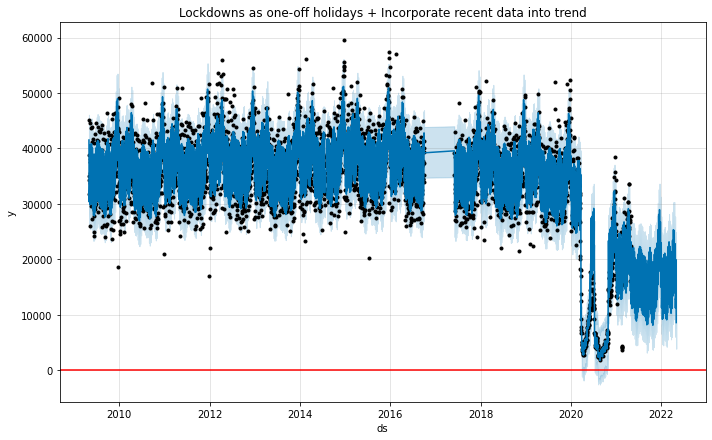

In [17]:
m3.plot(forecast3)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Incorporate recent data into trend')

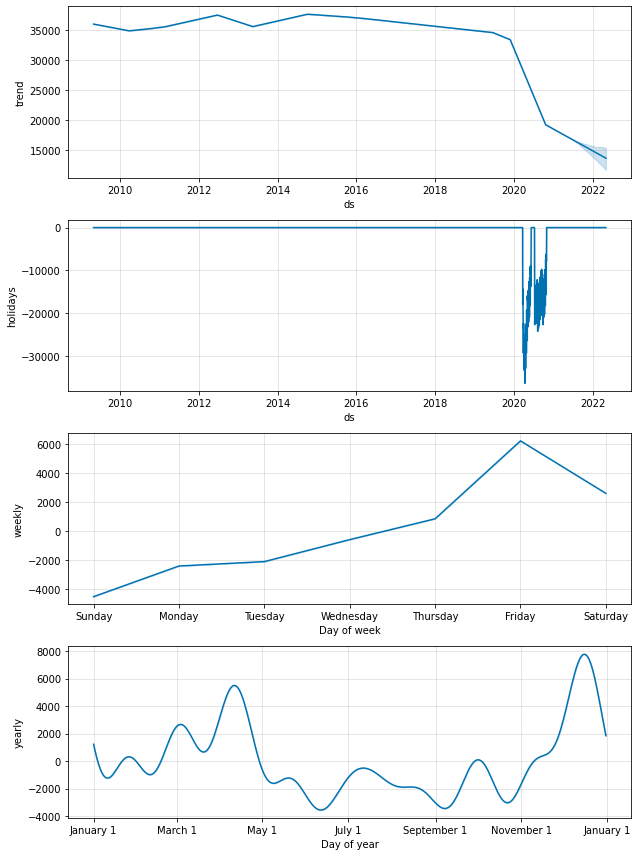

In [18]:
m3.plot_components(forecast3)
plt.show()

We can see the difference in the trend estimation between this model and the model fitted in the previous section.

* Instead of the trend continuing to slope down, there is a little elbow towards the end of 2020, when the second lockdown was lifted.
* The projected pedestrian values are now more stable around the level of the most recent data, instead trending downwards towards 0.

### Changes in seasonality between pre- and post-COVID

As we mentioned in the introduction, COVID (both the virus and the lockdowns) could also affect people's routines, to the point where seasonality patterns pre-COVID no longer hold. 

For our case study of pedestrian activity, the day-of-week seasonality of our models in the previous sections shows that there was a lot more activity on Friday (and to an extent Thursday and Saturday) compared to other days of the week. If we're not sure whether this will still hold after lockdowns are lifted (especially given that vaccines weren't yet rolled out widely when the lockdown was lifted), we can add _conditional seasonalities_ to the model. Conditional seasonalities are explained in more detail [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#seasonalities-that-depend-on-other-factors).

First we define boolean columns in the history dataframe that flag "pre covid" and "post covid" times:

In [19]:
df2 = df.copy()

In [20]:
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')

In [21]:
df2['post_covid'] = ~df2['pre_covid']

The conditional seasonality we're interested in modelling here is the day-of-week ("weekly") seasonality (i.e. is there still a spike in pedestrian activity on Fridays?). To do this, we firstly turn off the default `weekly_seasonality` when we create the Prophet model.

In [22]:
m4 = Prophet(holidays=lockdowns, changepoint_range=0.9930, weekly_seasonality=False)

We then add this weekly seasonality manually, as two different model components - one for pre-covid, one for post-covid. Note that `fourier_order=3` is the default setting for weekly seasonality. After this we can run `.fit()`.

In [23]:
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)

In [24]:
m4.fit(df2)

During the prediction phase, we also need to create the `pre_covid` and `post_covid` flags in the future dataframe. This is so that Prophet can apply the correct weekly seasonality parameters to each datapoint.

In [25]:
future4 = m4.make_future_dataframe(periods=366)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']

In [26]:
forecast4 = m4.predict(future4)

Text(0.5, 1.0, 'Lockdowns as one-off holidays + Incorporate recent data into trend + Conditional weekly seasonality')

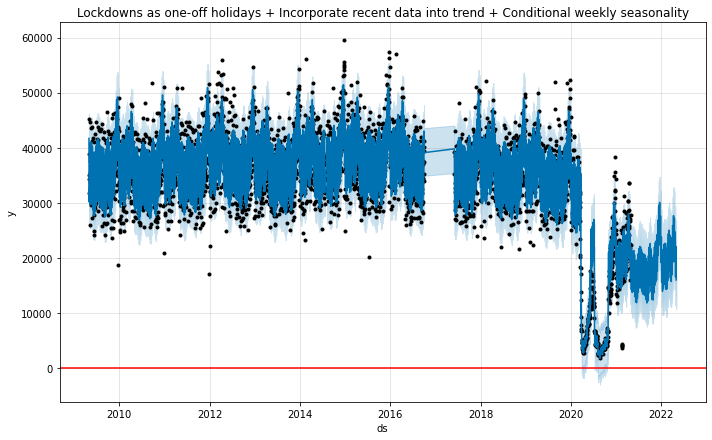

In [27]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Incorporate recent data into trend + Conditional weekly seasonality')

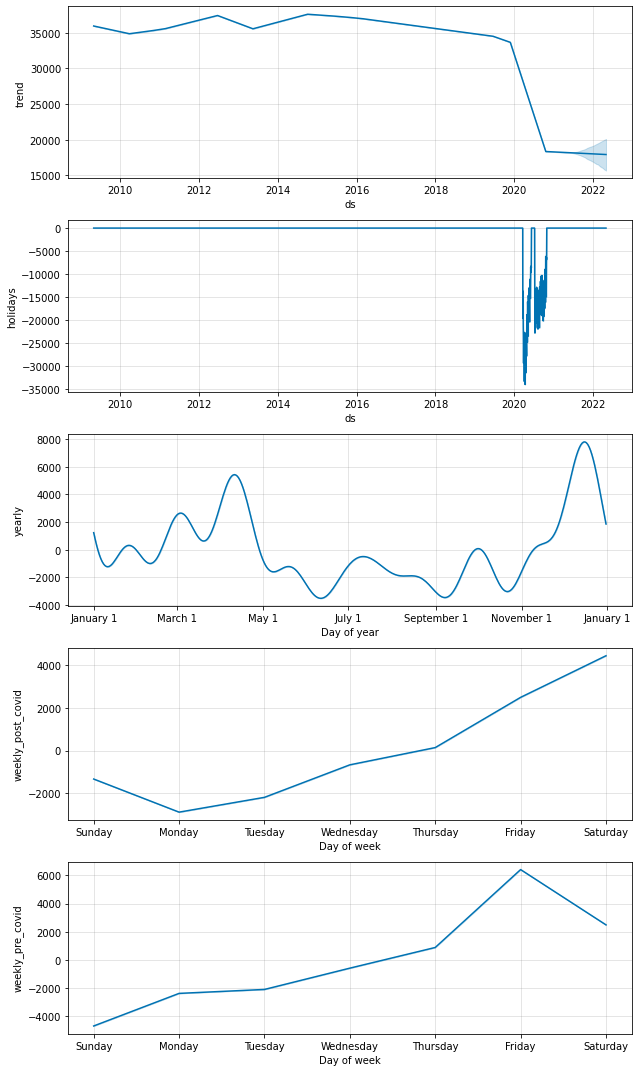

In [28]:
m4.plot_components(forecast4)
plt.show()

* Interestingly, the model with conditional seasonalities suggests that, post-COVID, pedestrian activity peaks on Saturdays, instead of Fridays. This could make sense if most people are still working from home and are hence less likely to go out on Friday nights.
* At a glance, the overall level of the predictions don't change too much, but the trend does flatten out more. The model's predictions of Fridays and Saturdays could also be materially different from our previous models.

This model makes sense intuitively, but if prediction accuracy is the main concern, we'd want to use [cross validation](https://facebook.github.io/prophet/docs/diagnostics.html) to assess whether it performs better than our previous models.

### Further reading

The case study presented above may not be suitable to all contexts. See the following thread for a more extensive discussion of different strategies for handling the impact of COVID-19 in different contexts:

* https://github.com/facebook/prophet/issues/1416

See also these articles:

* [How to forecast demand despite COVID](https://medium.com/swlh/how-to-forecast-demand-despite-covid-82d22a0a6ff7)